# Evaluation of text similarity metrics using GLUE tasks

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import transformers

from bert_score import BERTScorer
from datasets import load_dataset
from transformers import logging
logging.set_verbosity_error()


class STSScorer:
    def __init__(self):
        model_name = 'WillHeld/roberta-base-stsb'
        self._sts_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self._sts_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
        self._sts_model.eval()

    def score(self, sentence1, sentence2):
        sts_tokenizer_output = self._sts_tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt")
        sts_model_output = self._sts_model(**sts_tokenizer_output)
        return sts_model_output['logits'].item()/5

scorer = BERTScorer(lang="en", rescale_with_baseline=True)
bleu = evaluate.load("bleu")
stsb_scorer = STSScorer()

def fetch_scores(scorer, bleu, data, feature1, feature2):
    print(len(data))
    scores = []
    count = 0
    for instance in data:
        bert_score = scorer.score([instance[feature1]], [instance[feature2]], verbose=False)
        bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
        stsb_score = stsb_scorer.score(instance[feature1], instance[feature2])
        scores.append({'label': instance['label'], 'bertscore_precision': bert_score[0].item(), 'bertscore_recall': bert_score[1].item(), 'bertscore_f1': bert_score[2].item(), 'bleu': bleu_score, 'sts_score': stsb_score})
        count += 1
        if count % 1000 == 0:
            print(count)
        if count > 100:
            #break
            pass
    return scores

/home/sherbold/git/eval-semantic-similarity/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## STS-B

1379
1000


/home/sherbold/git/eval-semantic-similarity/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sherbold/git/eval-semantic-similarity/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sherbold/git/eval-semantic-similarity/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sherbold/git/eval-semantic-similarity/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

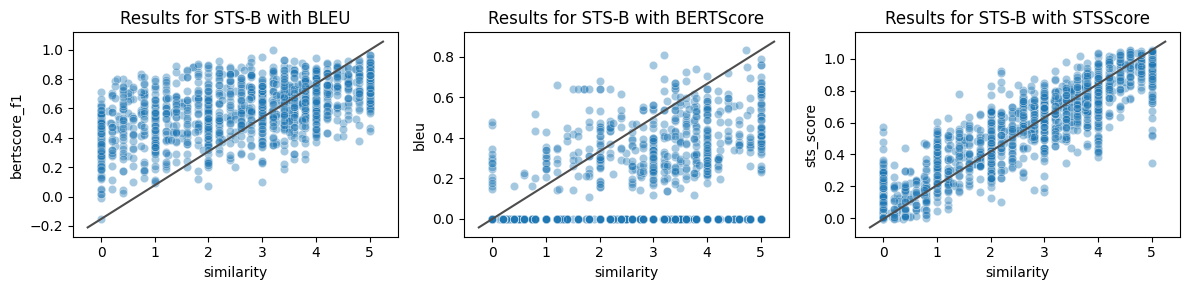

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0.000,0.392950,0.397847,0.395798,0.036948,0.122519
0.133,0.577692,0.578559,0.578811,0.000000,0.030649
0.167,0.439641,0.561344,0.500627,0.000000,0.007752
0.188,0.415110,0.591955,0.502908,0.000000,0.031646
0.200,0.401272,0.427430,0.414889,0.000000,0.108364
...,...,...,...,...,...
4.600,0.745375,0.738563,0.742038,0.160373,0.937417
4.733,0.869135,0.869016,0.869288,0.833079,1.038682
4.750,0.686517,0.736469,0.711809,0.252913,0.953531


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0.000,0.166911,0.174171,0.161480,0.100683,0.131912
0.133,NaN,NaN,NaN,NaN,NaN
0.167,NaN,NaN,NaN,NaN,NaN
0.188,NaN,NaN,NaN,NaN,NaN
0.200,0.177724,0.205286,0.186020,0.000000,0.099843
...,...,...,...,...,...
4.600,0.113964,0.104313,0.099572,0.211014,0.088840
4.733,NaN,NaN,NaN,NaN,NaN
4.750,0.116524,0.141335,0.127967,0.356348,0.023843


In [2]:
data = load_dataset("stsb_multi_mt", name="en", split="test")
data = data.rename_column("similarity_score", "label")
scores_stsb = pd.DataFrame(fetch_scores(scorer, bleu, data, 'sentence1', 'sentence2'))

def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.scatterplot(x="label", y="bleu", data=scores_stsb, alpha=0.4, ax=axes[0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_stsb, alpha=0.4, ax=axes[1])
sns.scatterplot(x="label", y="sts_score", data=scores_stsb, alpha=0.4, ax=axes[2])
draw_diagonal(axes[0])
draw_diagonal(axes[1])
draw_diagonal(axes[2])
axes[0].set_title("Results for STS-B with BLEU")
axes[0].set_xlabel("similarity")
axes[1].set_title("Results for STS-B with BERTScore")
axes[1].set_xlabel("similarity")
axes[2].set_title("Results for STS-B with STSScore")
axes[2].set_xlabel("similarity")
fig.tight_layout()
plt.savefig('plots/stsb.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_stsb.groupby('label').mean())
print('Standard deviation')
display(scores_stsb.groupby('label').std())
scores_stsb.to_csv('scores/stsb.csv')

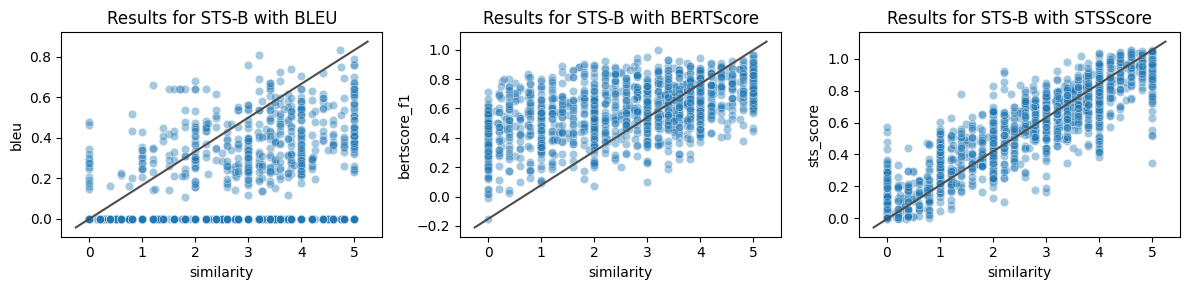

Pearson correlation


bleu            0.337758
bertscore_f1    0.528701
sts_score       0.895954
Name: label, dtype: float64

Spearman correlation


bleu            0.322598
bertscore_f1    0.527129
sts_score       0.889745
Name: label, dtype: float64

In [35]:
scores_stsb = pd.read_csv('scores/stsb.csv')

def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.scatterplot(x="label", y="bleu", data=scores_stsb, alpha=0.4, ax=axes[0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_stsb, alpha=0.4, ax=axes[1])
sns.scatterplot(x="label", y="sts_score", data=scores_stsb, alpha=0.4, ax=axes[2])
draw_diagonal(axes[0])
draw_diagonal(axes[1])
draw_diagonal(axes[2])
axes[0].set_title("Results for STS-B with BLEU")
axes[0].set_xlabel("similarity")
axes[1].set_title("Results for STS-B with BERTScore")
axes[1].set_xlabel("similarity")
axes[2].set_title("Results for STS-B with STSScore")
axes[2].set_xlabel("similarity")
fig.tight_layout()
plt.savefig('plots/stsb.pdf', bbox_inches='tight')
plt.show()

print('Pearson correlation')
display(scores_stsb.corr(method='pearson')['label'][['bleu', 'bertscore_f1', 'sts_score']])
print('Spearman correlation')
display(scores_stsb.corr(method='spearman')['label'][['bleu', 'bertscore_f1', 'sts_score']])

## MRPC

In [24]:
data = load_dataset('glue', 'mrpc')['test']
scores_mrpc = pd.DataFrame(fetch_scores(scorer, bleu, data, 'sentence1', 'sentence2'))
scores_mrpc.to_csv('scores/mrpc.csv')

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 1537.13it/s]


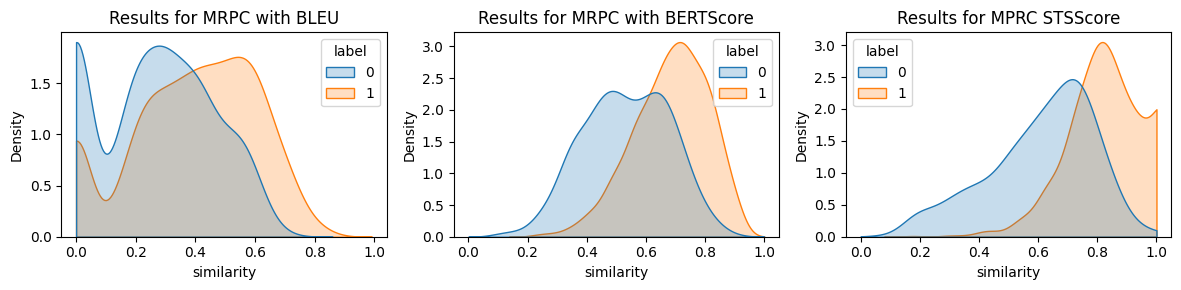

Mean


,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,,,,,,,,,,,,,,,
0,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,887.468858,0.535354,0.530233,0.532616,0.260324,0.610237
1,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,849.165650,0.684321,0.682521,0.683187,0.392253,0.837354


Standard deviation


,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,,,,,,,,,,,,,,,
0,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,505.174105,0.159769,0.164882,0.145341,0.191747,0.180009
1,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,494.234810,0.142888,0.139676,0.125755,0.209861,0.134796


In [23]:
scores_mrpc = pd.read_csv('scores/mrpc.csv')
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.kdeplot(scores_mrpc, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0])
sns.kdeplot(scores_mrpc, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1])
sns.kdeplot(scores_mrpc, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[2])
axes[0].set_title("Results for MRPC with BLEU")
axes[0].set_xlabel("similarity")
axes[1].set_title("Results for MRPC with BERTScore")
axes[1].set_xlabel("similarity")
axes[2].set_title("Results for MPRC STSScore")
axes[2].set_xlabel("similarity")
sns.move_legend(axes[2], "upper left")
fig.tight_layout()
plt.savefig('plots/mrpc.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())

## QQP

In [27]:
data = load_dataset('glue', 'qqp')['train']
scores_qqp = pd.DataFrame(fetch_scores(scorer, bleu, data, 'question1', 'question2'))
scores_qqp.to_csv('scores/qqp.csv')

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 367.89it/s]


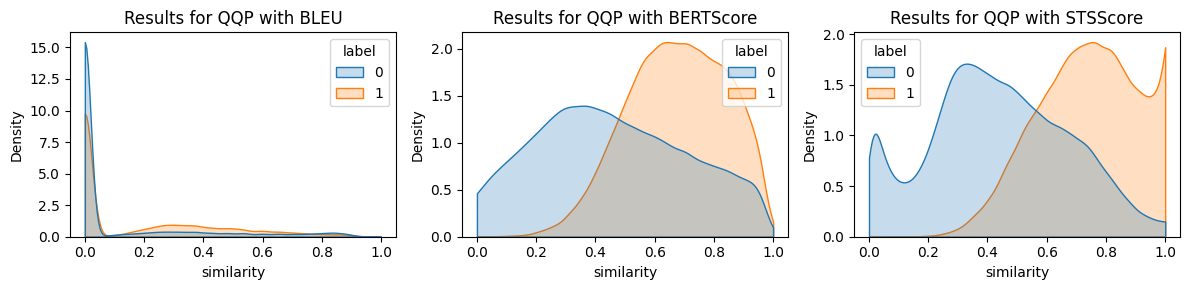

Mean


,Unnamed: 0.1,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,,,
0,182006.746963,182006.746963,0.438191,0.444688,0.441274,0.113036,0.439641
1,181778.637299,181778.637299,0.673945,0.673659,0.673431,0.184540,0.762966


Standard deviation


,Unnamed: 0.1,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,,,
0,105000.718917,105000.718917,0.275215,0.275584,0.264823,0.232932,0.236197
1,105089.519470,105089.519470,0.180303,0.180175,0.166039,0.249377,0.181817


In [28]:
scores_qqp = pd.read_csv('scores/qqp.csv')
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.kdeplot(scores_qqp, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0])
sns.kdeplot(scores_qqp, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1])
sns.kdeplot(scores_qqp, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[2])
axes[0].set_title("Results for QQP with BLEU")
axes[0].set_xlabel("similarity")
axes[1].set_title("Results for QQP with BERTScore")
axes[1].set_xlabel("similarity")
axes[2].set_title("Results for QQP with STSScore")
axes[2].set_xlabel("similarity")
sns.move_legend(axes[2], "upper left")
fig.tight_layout()
plt.savefig('plots/qqp.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_qqp.groupby('label').mean())
print('Standard deviation')
display(scores_qqp.groupby('label').std())